In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import yaml

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{amssymb}'

## Figure 1

In [63]:
import torch
from main import CustomDataset


def sample_points(embed_dim = 5000, signal_norm = 15, noise_strength = 0.05):
    train_n = 100
    test_n = 100
    T = 8
    rho = 0.2

    vmu_1 = torch.zeros(embed_dim)
    vmu_2 = torch.zeros(embed_dim)
    vmu_1[0] = signal_norm
    vmu_2[1] = signal_norm

    train_dataset = CustomDataset(train_n, T, embed_dim, vmu_1, vmu_2, rho, noise_ratio=0.2)
    test_dataset = CustomDataset(test_n, T, embed_dim, vmu_1, vmu_2, rho, noise_ratio=0.0)
    noise_component = torch.zeros(embed_dim)
    # Add noise component for each noisy training sample
    for i, is_noisy in enumerate(train_dataset.noisy_data_mask):
        if is_noisy:
            noise_component += train_dataset.data[i, 2] - rho * (vmu_1 if train_dataset.label[i] == 1 else vmu_2)
        else:
            noise_component += train_dataset.data[i, 0] - (vmu_1 if train_dataset.label[i] == 1 else vmu_2)

    def calc_attention_scores(x):
        p = (vmu_1 + vmu_2 + noise_strength * noise_component)
        attention_logits = (x @ p).squeeze(-1)
        return torch.softmax(attention_logits, dim=-1).numpy()

    # Projections to vmu_1 and vmu_2 directions. They equal to the 0-th and 1-st components of vectors.
    train_vmu_1 = []
    train_vmu_2 = []
    test_vmu_1 = []
    test_vmu_2 = []
    for x in train_dataset.data:
        attention_scores = calc_attention_scores(x)
        selected_token = x[np.argmax(attention_scores)]
        train_vmu_1.append(selected_token[0].item())
        train_vmu_2.append(selected_token[1].item())
    for x in test_dataset.data:
        attention_scores = calc_attention_scores(x)
        selected_token = x[np.argmax(attention_scores)]
        test_vmu_1.append(selected_token[0].item())
        test_vmu_2.append(selected_token[1].item())

    train_count = 0
    test_count = 0
    for i, y in enumerate(train_dataset.label):
        if (train_vmu_1[i] > train_vmu_2[i]) and y == 1:
            train_count += 1
        if (train_vmu_1[i] < train_vmu_2[i]) and y == -1:
            train_count += 1
    for i, y in enumerate(test_dataset.label):
        if (test_vmu_1[i] > test_vmu_2[i]) and y == 1:
            test_count += 1
        if (test_vmu_1[i] < test_vmu_2[i]) and y == -1:
            test_count += 1
    print(f"Train acc: {train_count / len(train_dataset.label)}, Test acc: {test_count / len(test_dataset.label)}")
    return train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_dataset.label, test_dataset.label

Train acc: 1.0, Test acc: 1.0
Train acc: 1.0, Test acc: 0.63
Train acc: 0.8, Test acc: 1.0


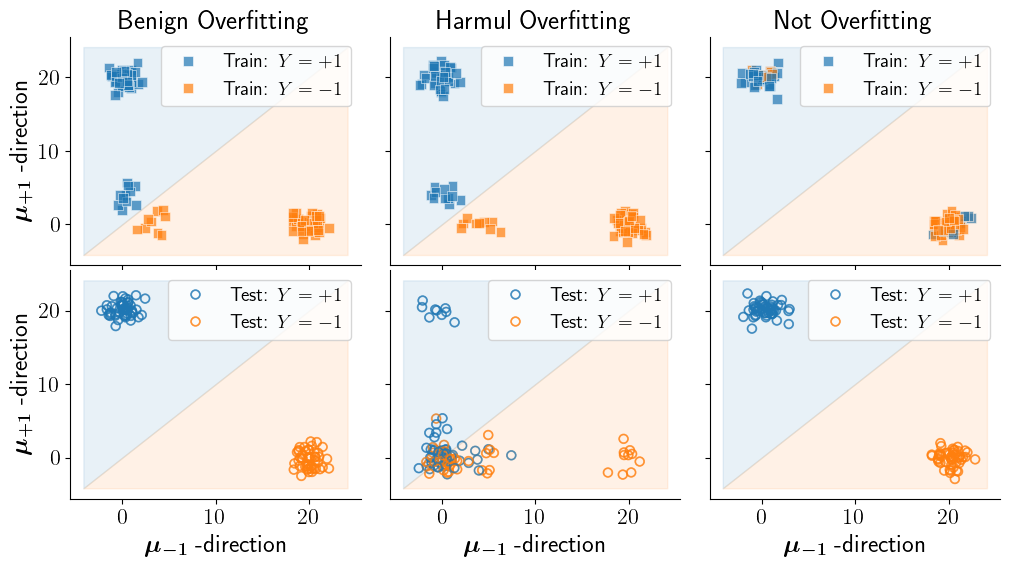

In [ ]:
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.02, wspace=0.1))

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.06)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][0], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][0], marker='s', palette="tab10", alpha=0.7)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 1)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][1], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][1], marker='s', palette="tab10", alpha=0.7)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.001)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][2], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][2], marker='s', palette="tab10", alpha=0.7)

xyrange = (0,0)
for ax in axs.flatten():
    xyrange = (min(xyrange[0], ax.get_xlim()[0], ax.get_ylim()[0]), max(xyrange[1], ax.get_xlim()[1], ax.get_ylim()[1]))

labels = ["Train: $Y=+1$", "Train: $Y=-1$"]
for ax in axs[0]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

labels = ["Test: $Y=+1$", "Test: $Y=-1$"]
for ax in axs[1]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

axs[1][0].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][1].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][2].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)

axs[0][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)
axs[1][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)

axs[0][0].set_title("Benign Overfitting")
axs[0][1].set_title("Harmul Overfitting")
axs[0][2].set_title("Not Overfitting")

plt.show()

/tmp/ipykernel_64982/1317875388.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


Train acc: 1.0, Test acc: 0.62
Train acc: 1.0, Test acc: 1.0
Train acc: 0.8, Test acc: 1.0


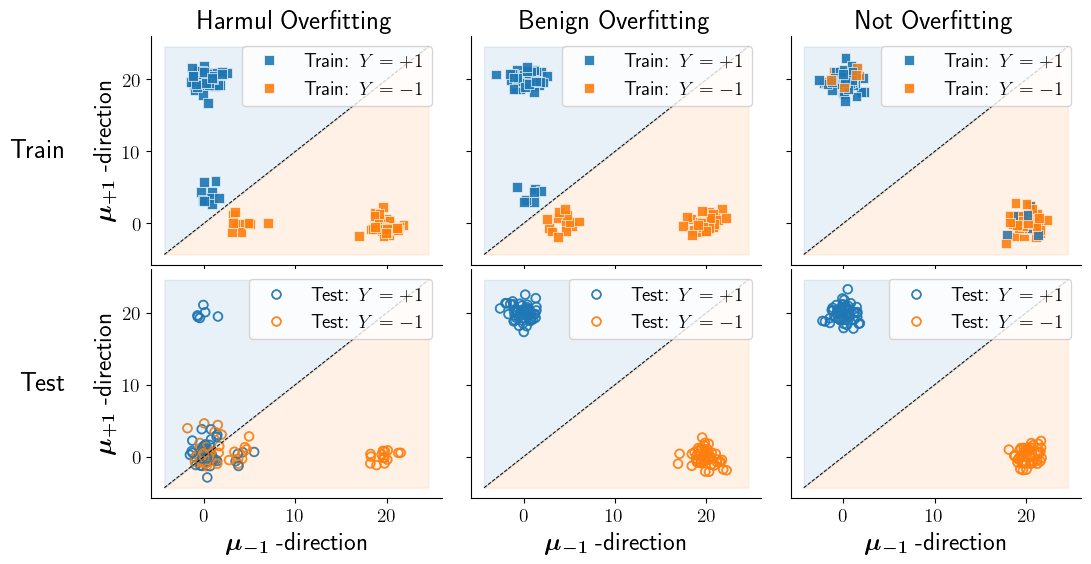

In [134]:
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.02, wspace=0.1))
cmap = cm.get_cmap("tab10")

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 1)
test_misclassified = np.array([0.9  if (l == 1 and x < y) or (x == -1 and x > y) else 0.5 for (l, x, y) in zip(test_label, test_vmu_1, test_vmu_2)])
train_misclassified = np.array([0.9  if (l == 1 and x < y) or (x == -1 and x > y) else 0.5 for (l, x, y) in zip(train_label, train_vmu_1, train_vmu_2)])

sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][0], palette="tab10", alpha=0.9, edgecolor="face", marker="$\circ$")
# colors = [cmap((l + 1) // 2 ) for l in test_label]
# axs[1][0].scatter(test_vmu_1, test_vmu_2, s=50, c=colors, alpha=test_misclassified, marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][0], marker='s', palette="tab10", alpha=0.9)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.06)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][1], palette="tab10", alpha=0.9, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][1], marker='s', palette="tab10", alpha=0.9)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.001)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][2], palette="tab10", alpha=0.9, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][2], marker='s', palette="tab10", alpha=0.9)

xyrange = (0,0)
for ax in axs.flatten():
    xyrange = (min(xyrange[0], ax.get_xlim()[0], ax.get_ylim()[0]), max(xyrange[1], ax.get_xlim()[1], ax.get_ylim()[1]))

labels = ["Train: $Y=+1$", "Train: $Y=-1$"]
# labels = ["$Y=+1$", "$Y=-1$"]
for ax in axs[0]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

labels = ["Test: $Y=+1$", "Test: $Y=-1$"]
# labels = ["$Y=+1$", "$Y=-1$"]
for ax in axs[1]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

x = np.linspace(xyrange[0], xyrange[1], 100)
for ax in axs.flatten():
    ax.plot(x, x, color="black", linestyle="--", linewidth=0.7)
    ax.tick_params(labelsize=14)

for r, ax in zip(["Train", "Test"], axs[:, 0]):
    ax2 = ax.twinx()
    # move extra axis to the left, with offset
    ax2.yaxis.set_label_position('left')
    ax2.spines['left'].set_position(('axes', -0.28))
    # hide spine and ticks, set group label
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_yticks([])
    ax2.set_ylabel(r, rotation=0, size='large',
                   ha='right', va='center')

axs[1][0].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][1].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][2].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)

axs[0][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)
axs[1][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)

axs[0][0].set_title("Harmul Overfitting")
axs[0][1].set_title("Benign Overfitting")
axs[0][2].set_title("Not Overfitting")

plt.show()

In [6]:
plt.rcParams['font.size'] = 18

def find_matching_path_and_dict(condition) -> list[tuple[str, dict]]:
    res = []
    for dir in os.listdir("./outputs"):
        for subdir in os.listdir(os.path.join("./outputs", dir)):
            config_path = os.path.join("./outputs", dir, subdir, ".hydra/config.yaml")
            assert os.path.exists(config_path)
            with open(config_path, "r") as f:
                try:
                    config = yaml.safe_load(f)
                    if condition(config):
                        res.append((os.path.join("./outputs", dir, subdir), config))
                except:
                    pass
    return res

### (a) Balanced Setting

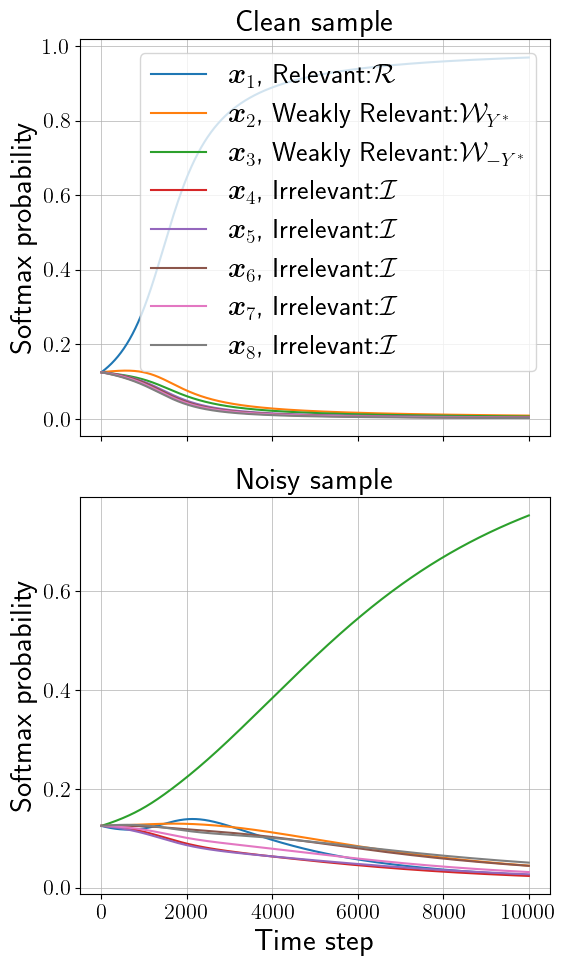

In [21]:
# path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 2000 and x["signal_norm"] == 20 and x["noise_ratio"] == 0.2)[0][0]
path = "./outputs/2024-09-11/00-36-49"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[0]

fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant:$\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant:$\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant:$\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant:$\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)
axs[0].legend(fontsize=20)

df = pd.read_csv(os.path.join(path, "attention_scores.csv"))

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


1.0 0.996


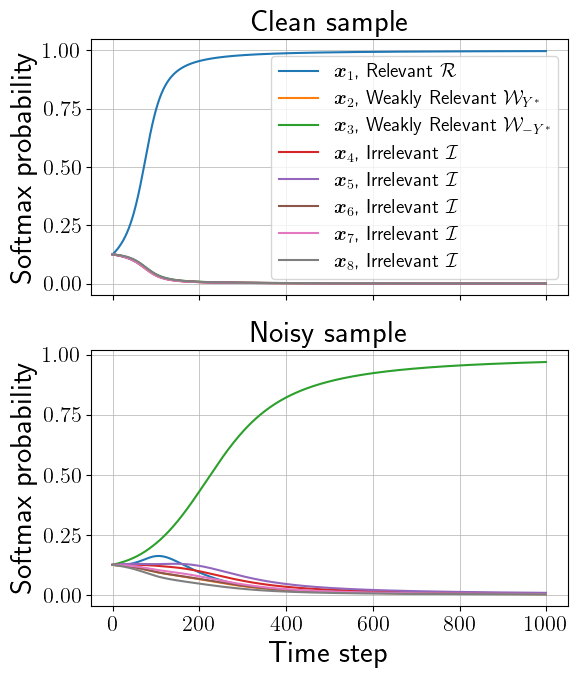

In [16]:
# path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 2000 and x["signal_norm"] == 20 and x["noise_ratio"] == 0.2)[0][0]
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-12-46"
# path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-18-19"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[1]

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(2, 1, figsize=(6, 7), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant $\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant $\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant $\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant $\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant $\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant $\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant $\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant $\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

axs[0].legend(fontsize=14)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


### (a') Large Label Noise (Balanced Setting)

1.0 1.0


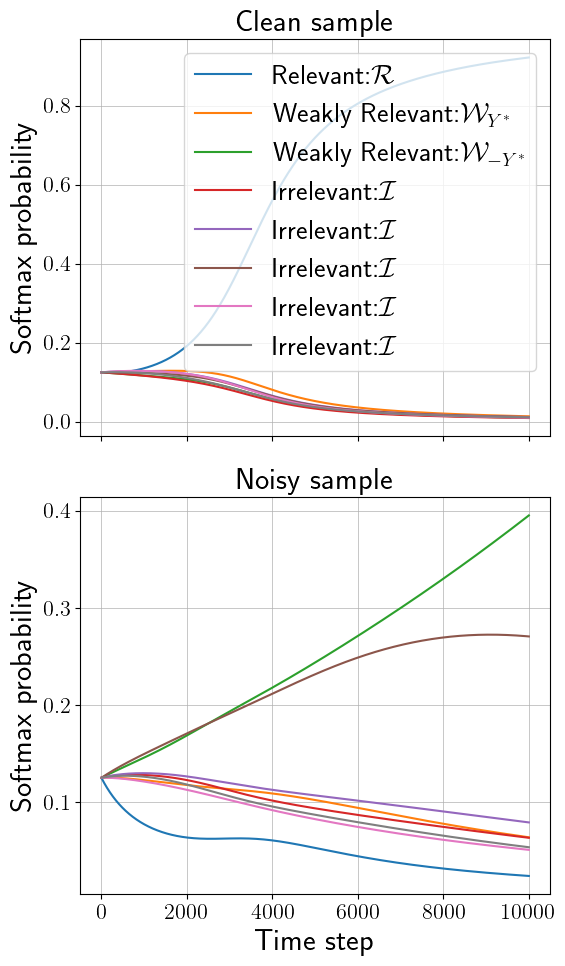

In [9]:
# path = "/work/gu14/k36078/benign-attention/multirun/2024-11-13/23-56-19/0" # noise_ratio=0.3
# path = "/work/gu14/k36078/benign-attention/multirun/2024-11-13/23-56-19/1" # noise_ratio=0.4
# path = "/work/gu14/k36078/benign-attention/multirun/2024-11-13/23-56-19/2" #noise_ratio=0.6

df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[0]

fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        label = r'Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)
axs[0].legend(fontsize=20)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df["train_accuracy"].values[-1], df["test_accuracy"].values[-1])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


### (b) Large Noise Setting

1.0 0.867


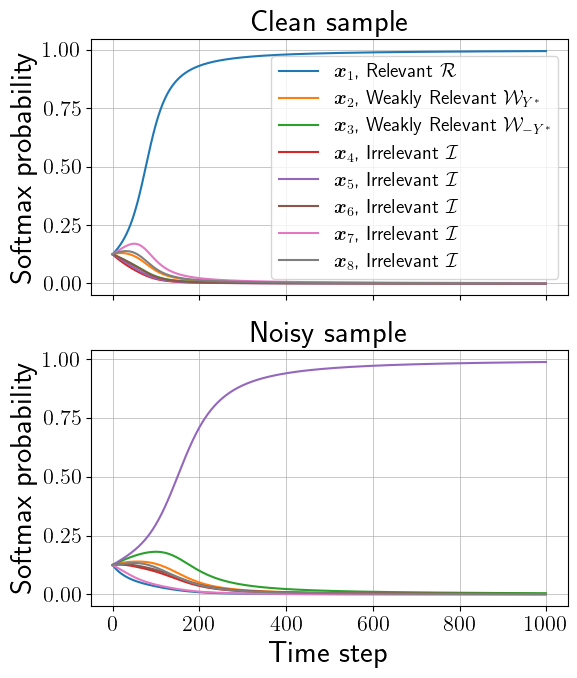

In [15]:
# path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 4500 and x["signal_norm"] == 5)[0][0]
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-20-53"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[-1]

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

# fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(6, 7), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant $\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant $\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant $\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant $\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant $\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant $\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant $\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant $\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

axs[0].legend(fontsize=14)

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

### (c) Large Signal Setting

2 11 0
0.8 1.0


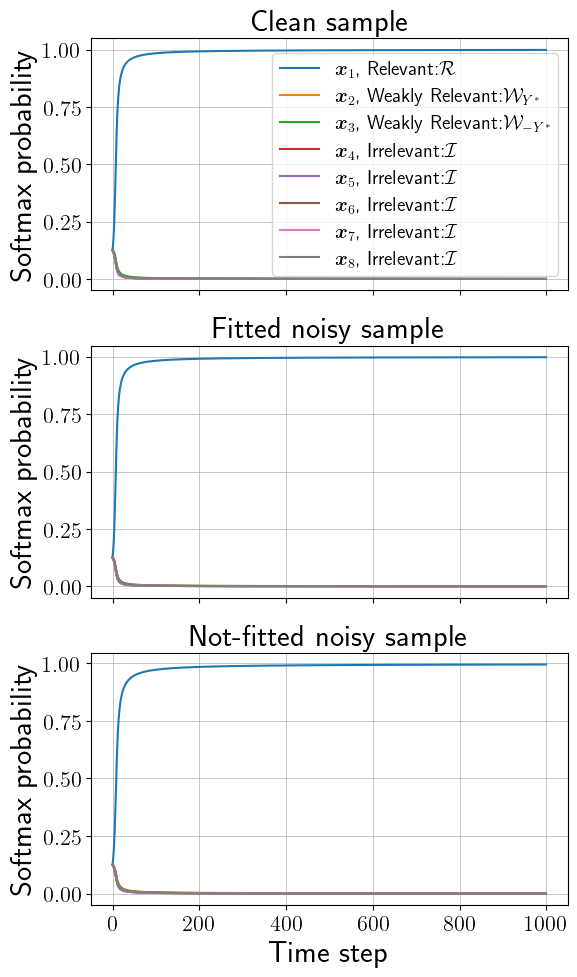

In [7]:
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-13/03-36-54"
# path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-36-17"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = 11
sample_id_noisy_1 = 0
print(sample_id_clean, sample_id_noisy, sample_id_noisy_1)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(3, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant:$\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant:$\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant:$\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant:$\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy_1) & (df["token_id"] == token_id)][:1000], ax=axs[1])
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[2])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Fitted noisy sample", fontsize=22)
axs[2].set_title("Not-fitted noisy sample", fontsize=22)

axs[0].legend(fontsize=14)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

0.8 1.0


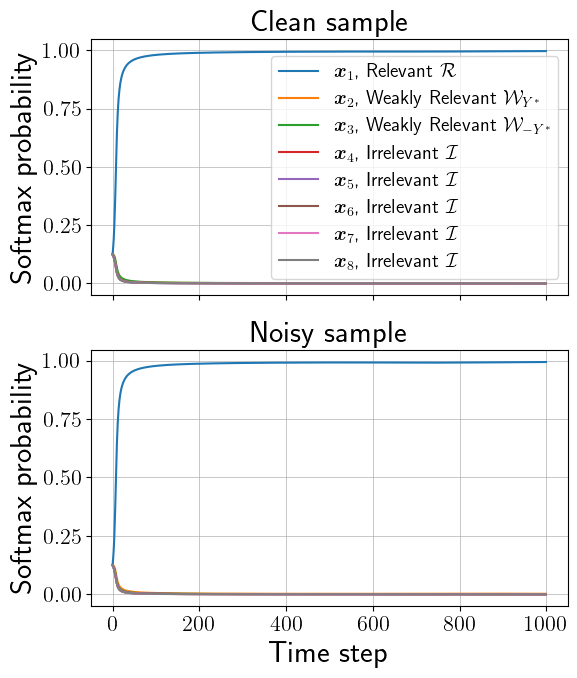

In [3]:
path = "/work/gu14/k36078/benign-attention/outputs/2025-01-13/17-34-34"
# path = "/work/gu14/k36078/benign-attention/outputs/2025-01-12/22-36-17"
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = 0

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(2, 1, figsize=(6, 7), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'$\boldsymbol{x}_1$, Relevant $\mathcal{R}$'
    elif token_id == 1:
        label = r'$\boldsymbol{x}_2$, Weakly Relevant $\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'$\boldsymbol{x}_3$, Weakly Relevant $\mathcal{W}_{-Y^*}$'
    else:
        if token_id == 3:
            label = r'$\boldsymbol{x}_4$, Irrelevant $\mathcal{I}$'
        elif token_id == 4:
            label = r'$\boldsymbol{x}_5$, Irrelevant $\mathcal{I}$'
        elif token_id == 5:
            label = r'$\boldsymbol{x}_6$, Irrelevant $\mathcal{I}$'
        elif token_id == 6:
            label = r'$\boldsymbol{x}_7$, Irrelevant $\mathcal{I}$'
        elif token_id == 7:
            label = r'$\boldsymbol{x}_8$, Irrelevant $\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)][:1000], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)][:1000], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

axs[0].legend(fontsize=14)

df = pd.read_csv(os.path.join(path, "stats_time_step.csv"))
print(df[df["time_step"] == 1000]["train_accuracy"].values[0], df[df["time_step"] == 1000]["test_accuracy"].values[0])

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

## Figure 4

In [6]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])
            if key[0] not in embed_dim_list or key[1] not in signal_norm_list:
                continue

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res[key] = {
                "mathfrak_s_1": df["mathfrak_s_1"].values[-1],
                "mathfrak_s_2": df["mathfrak_s_2"].values[-1]
            }

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "attention_scores.csv"), "r") as f:
                df = pd.read_csv(f)
            res[key]["max_cumulative_attention"] = df.groupby("time_step", as_index=False)["cumulative_attention"].max()["cumulative_attention"].values[-1]

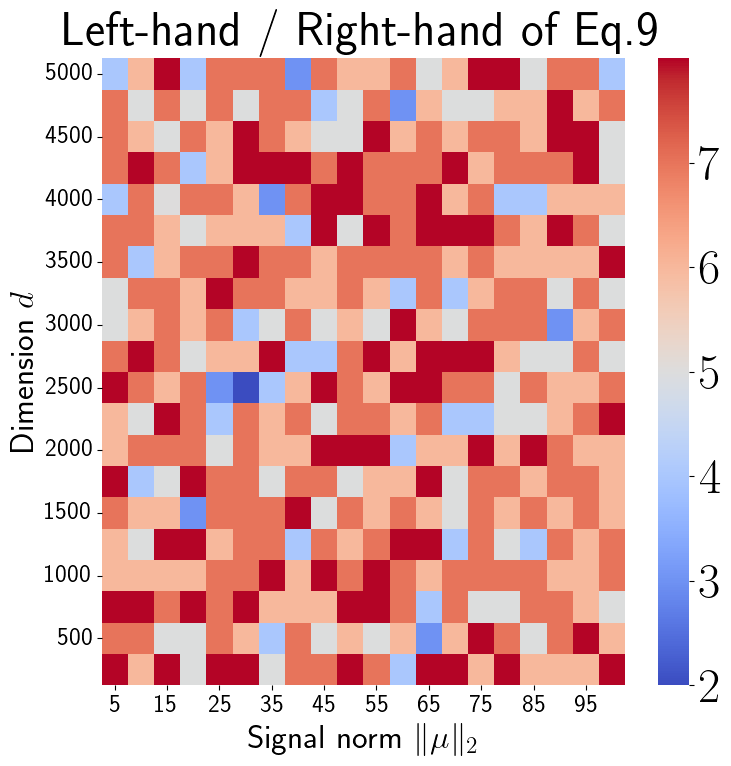

In [7]:
arr_2d = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d[i, j] = min(res[(ed, sn)]["mathfrak_s_1"], res[(ed, sn)]["mathfrak_s_2"]) / res[(ed, sn)]["max_cumulative_attention"]

df = pd.DataFrame(arr_2d, columns=signal_norm_list, index=embed_dim_list)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
sns.heatmap(df, ax=ax, cmap="coolwarm", annot_kws={"fontsize": 8})

ax.invert_yaxis()
current_yticks = ax.get_yticks()
ax.set_yticks(current_yticks[1::2])

ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
ax.set_ylabel("Dimension $d$", fontsize=24)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)

ax.set_title("Left-hand / Right-hand of Eq.9", fontsize=35)
plt.show()

## Figure 5

In [8]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res_loss = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res_loss[key] = {
                "train_loss": df["train_loss"].values[-1],
                "test_loss": df["test_loss"].values[-1]
            }

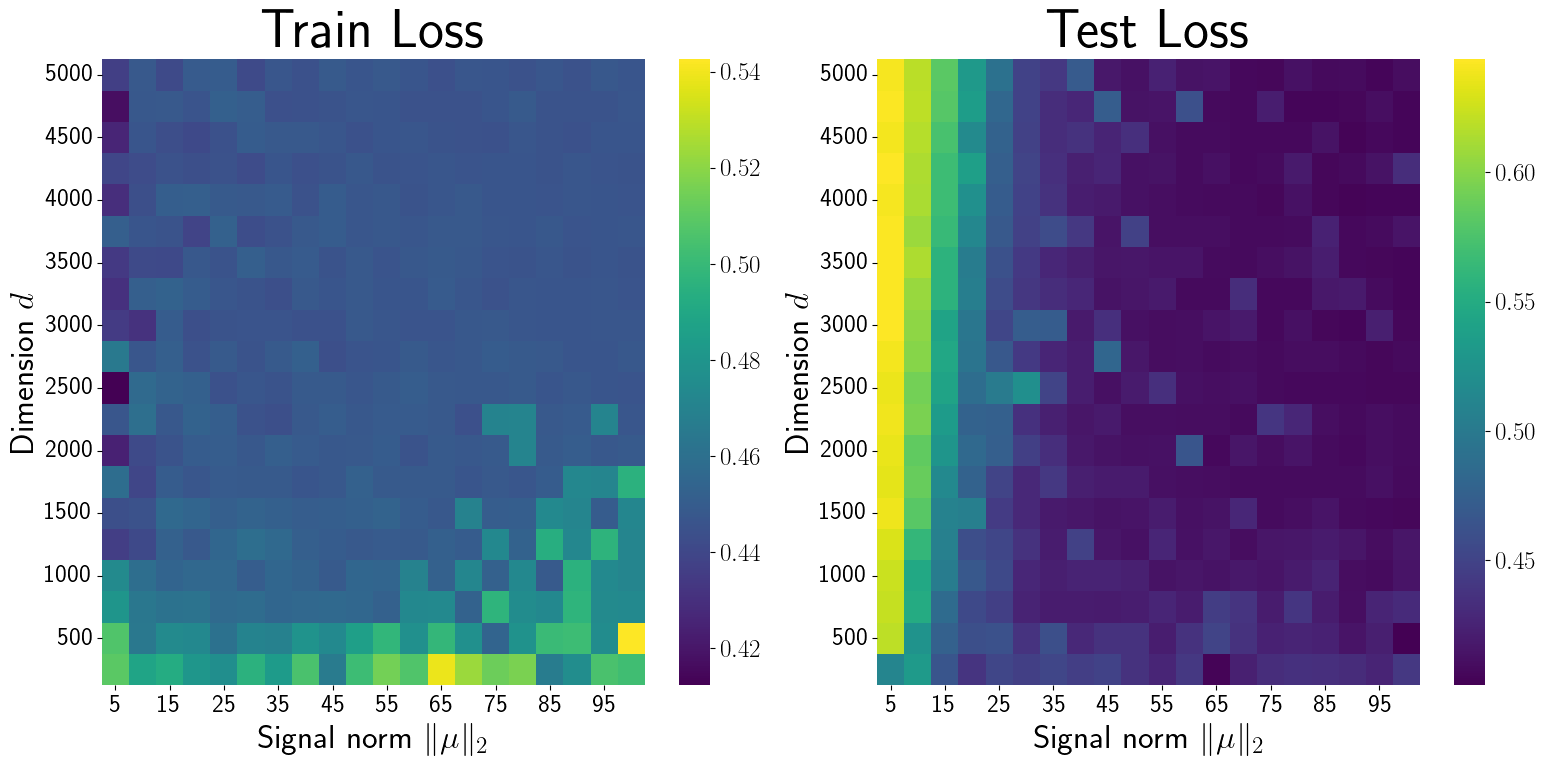

In [9]:
arr_2d_train_loss = np.zeros((20, 20))
arr_2d_test_loss = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d_train_loss[i, j] = res_loss[(ed, sn)]["train_loss"]
        arr_2d_test_loss[i, j] = res_loss[(ed, sn)]["test_loss"]

df_train_loss = pd.DataFrame(arr_2d_train_loss, columns=signal_norm_list, index=embed_dim_list)
df_test_loss = pd.DataFrame(arr_2d_test_loss, columns=signal_norm_list, index=embed_dim_list)
fig, axs = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
sns.heatmap(df_train_loss, fmt=".2f", ax=axs[0], cmap="viridis")
sns.heatmap(df_test_loss, fmt=".2f", ax=axs[1], cmap="viridis")

axs[1].set_xticks(axs[0].get_xticks())
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=360)
for ax in axs:
    ax.invert_yaxis()
    current_yticks = ax.get_yticks()
    ax.set_yticks(current_yticks[1::2])

    ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
    ax.set_ylabel("Dimension $d$", fontsize=24)

axs[0].set_title("Train Loss", fontsize=40)
axs[1].set_title("Test Loss", fontsize=40)
plt.show()

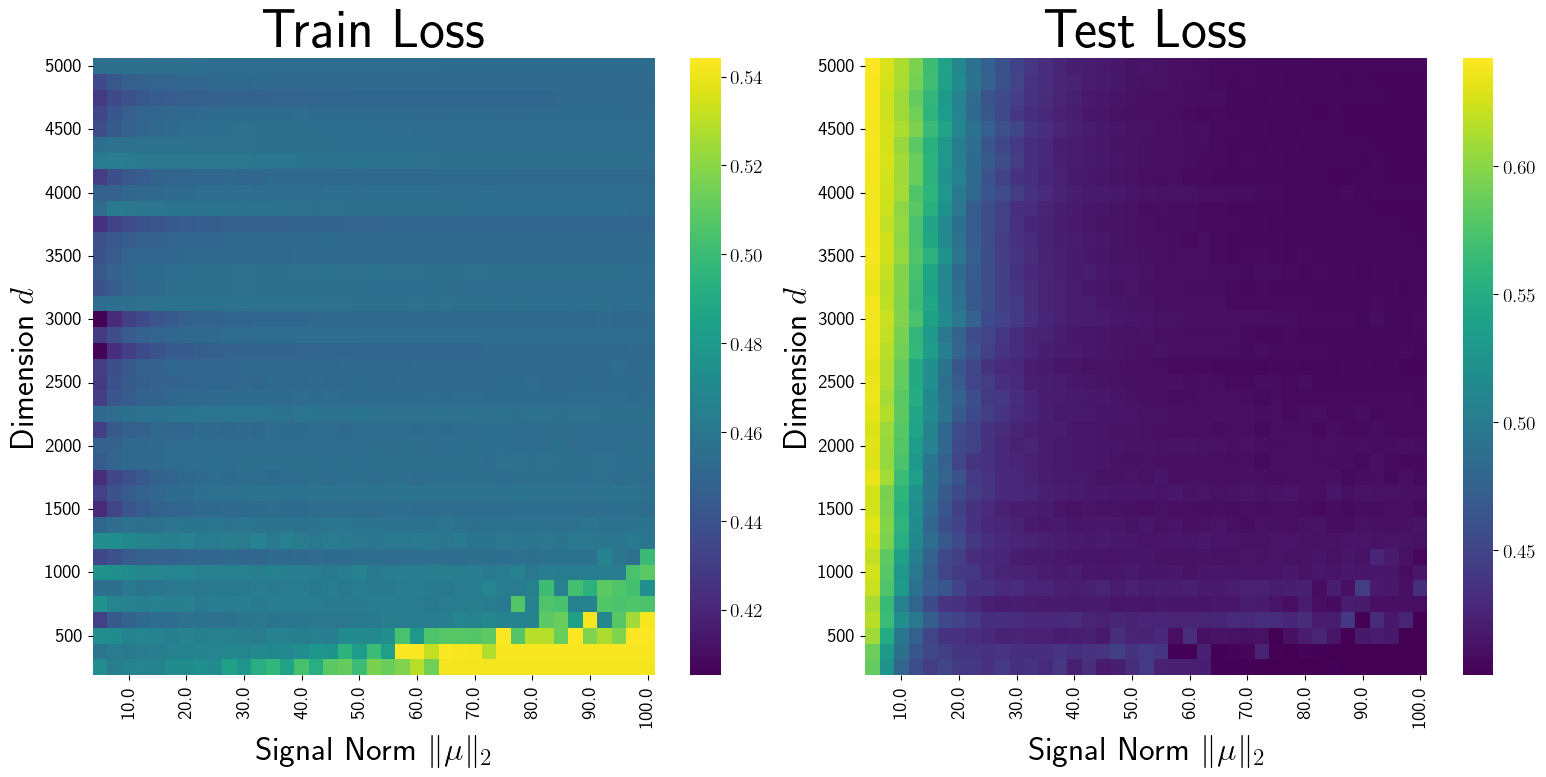

In [15]:
def fetch_dict(ed, sn, rho=0.1):
    if sn == int(sn):
        sn = int(sn)
    csv_path = os.path.join("./results/synthetic", f"d_{ed}", f"signal_{sn}", f"rho_{rho}", "stats_time_step.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} does not exist")
    with open(csv_path, "r") as f:
        df = pd.read_csv(f)
    return df

embed_dim_list = [250 + 125 * i for i in range(39)]
signal_norm_list = [5 + 2.5 * i for i in range(39)]

arr_2d_train_loss = np.zeros((len(embed_dim_list), len(signal_norm_list)))
arr_2d_test_loss = np.zeros((len(embed_dim_list), len(signal_norm_list)))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        df = fetch_dict(ed, sn)
        try:
            arr_2d_train_loss[i, j] = df[df["time_step"] == 999]["train_loss"].values[0]
            arr_2d_test_loss[i, j] = df[df["time_step"] == 999]["test_loss"].values[0]
        except:
            arr_2d_train_loss[i, j] = df[df["time_step"] == 990]["train_loss"].values[0]
            arr_2d_test_loss[i, j] = df[df["time_step"] == 990]["test_loss"].values[0]

df_train_loss = pd.DataFrame(arr_2d_train_loss, columns=signal_norm_list, index=embed_dim_list)
df_test_loss = pd.DataFrame(arr_2d_test_loss, columns=signal_norm_list, index=embed_dim_list)
fig, axs = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
sns.heatmap(df_train_loss, fmt=".2f", ax=axs[0], cmap="viridis")
sns.heatmap(df_test_loss, fmt=".2f", ax=axs[1], cmap="viridis")

# axs[1].set_xticks(axs[0].get_xticks())
# axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=360)
for ax in axs:
    ax.invert_yaxis()
    current_yticks = ax.get_yticks()
    ax.set_yticks(current_yticks[1::2])
    current_xticks = ax.get_xticks()
    ax.set_xticks(current_xticks[1::2])

    ax.set_xlabel("Signal Norm $\|\mathbf{\mu}\|_2$", fontsize=24)
    ax.set_ylabel("Dimension $d$", fontsize=24)

axs[0].set_title("Train Loss", fontsize=40)
axs[1].set_title("Test Loss", fontsize=40)
plt.show()

## Figure 6

In [10]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res_class = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])
            if key[0] not in embed_dim_list or key[1] not in signal_norm_list:
                continue

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res_class[key] = {
                "mathfrak_s_1_0": df["mathfrak_s_1"].values[0],
                "mathfrak_s_2_0": df["mathfrak_s_2"].values[0],
                "mathfrak_s_1": df["mathfrak_s_1"].values[-1],
                "mathfrak_s_2": df["mathfrak_s_2"].values[-1],
            }

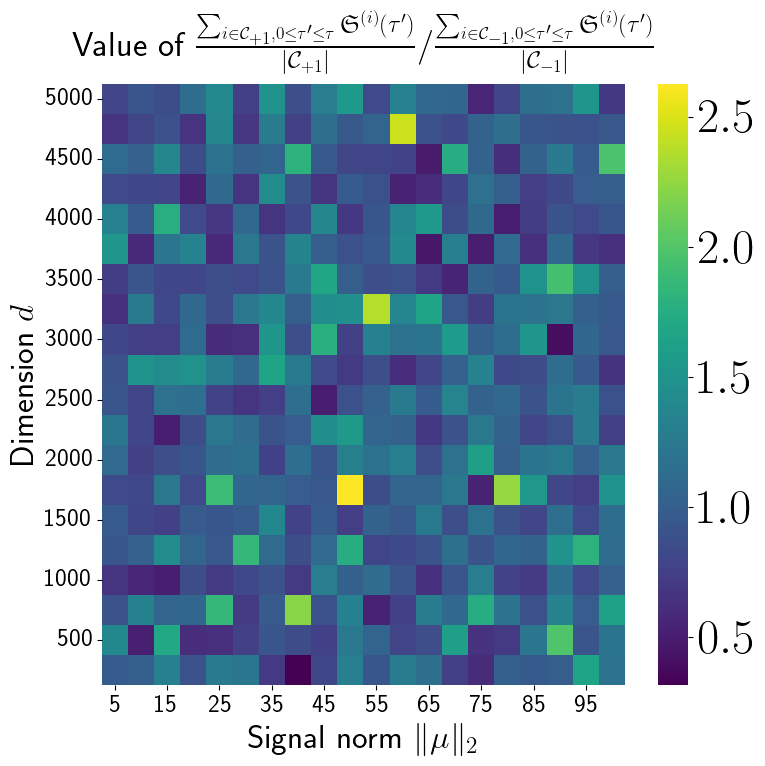

In [11]:
arr_2d = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d[i, j] = (res_class[(ed, sn)]["mathfrak_s_1"] / res_class[(ed, sn)]["mathfrak_s_2"]) / (res_class[(ed, sn)]["mathfrak_s_1_0"] / res_class[(ed, sn)]["mathfrak_s_2_0"])

df = pd.DataFrame(arr_2d, columns=signal_norm_list, index=embed_dim_list)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
sns.heatmap(df, fmt=".2f", ax=ax, cmap="viridis")

ax.invert_yaxis()
current_yticks = ax.get_yticks()
ax.set_yticks(current_yticks[1::2])

ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
ax.set_ylabel("Dimension $d$", fontsize=24)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)

ax.set_title("Value of $\\frac{\sum_{i\in\mathcal{C}_{+1}, 0\leq\\tau^\prime \leq\\tau} \mathfrak{S}^{(i)}(\\tau^\prime)}{|\mathcal{C}_{+1}|} / \\frac{\sum_{i\in\mathcal{C}_{-1}, 0\leq\\tau^\prime \leq\\tau} \mathfrak{S}^{(i)}(\\tau^\prime)}{|\mathcal{C}_{-1}|}$", fontsize=25, pad=20)
plt.show()

In [3]:
import os
import numpy as np
import json

model_names = ["vit"] * 5 + ["bert"] * 3
task_names = ["mnist", "cifar10", "stl10", "pneumoniamnist", "breastmnist", "sst2", "agnews", "trec"]
label_noises = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
seeds = [3, 4, 5]

for model_name, task_name in zip(model_names, task_names):
    test_accs = []
    for seed in seeds:
        path = os.path.join("./results", model_name, task_name, "noise_ratio_0.0", "pretrain", str(seed), "trainer_state.json")
        assert os.path.exists(path)
        with open(os.path.join(path), "r") as f:
            trainer_state = json.load(f)
        test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
    print(task_name, f"Baseline: {(np.mean(test_accs)*100):.2f} +- {(np.std(test_accs)*100):.2f}")
    for label_noise in label_noises:
        print(f"Noise {label_noise}:", end=" ")
        dir_path = os.path.join("./results", model_name, task_name, f"noise_ratio_{label_noise}", "finetune")
        assert os.path.exists(dir_path)

        train_losses = []
        test_accs = []
        for seed in seeds:
            path = os.path.join(dir_path, str(seed), "trainer_state.json")
            assert os.path.exists(path), f"{path} does not exist"
            with open(os.path.join(path), "r") as f:
                trainer_state = json.load(f)
            train_losses.append(trainer_state["log_history"][-3]["loss"])
            test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
        print(f"{np.mean(train_losses):.2f} +- {np.std(train_losses):.2f}, {(np.mean(test_accs)*100):.2f} +- {(np.std(test_accs)*100):.2f}")

mnist Baseline: 93.19 +- 0.17
Noise 0.0: 0.01 +- 0.00, 94.35 +- 0.20
Noise 0.1: 0.12 +- 0.02, 91.92 +- 0.21
Noise 0.2: 0.34 +- 0.05, 90.04 +- 0.86
Noise 0.3: 0.56 +- 0.06, 88.46 +- 0.89
Noise 0.4: 0.81 +- 0.09, 87.74 +- 1.01
Noise 0.5: 1.11 +- 0.10, 85.23 +- 1.01
cifar10 Baseline: 96.03 +- 0.04
Noise 0.0: 0.00 +- 0.00, 96.56 +- 0.09
Noise 0.1: 0.25 +- 0.02, 95.86 +- 0.19
Noise 0.2: 0.52 +- 0.04, 95.22 +- 0.33
Noise 0.3: 0.77 +- 0.06, 94.41 +- 0.32
Noise 0.4: 1.06 +- 0.07, 93.58 +- 0.39
Noise 0.5: 1.36 +- 0.07, 92.86 +- 0.29
stl10 Baseline: 99.52 +- 0.01
Noise 0.0: 0.00 +- 0.00, 99.49 +- 0.02
Noise 0.1: 0.31 +- 0.05, 99.28 +- 0.05
Noise 0.2: 0.66 +- 0.13, 99.05 +- 0.13
Noise 0.3: 0.99 +- 0.17, 98.80 +- 0.14
Noise 0.4: 1.30 +- 0.17, 98.33 +- 0.02
Noise 0.5: 1.69 +- 0.16, 98.00 +- 0.10
pneumoniamnist Baseline: 82.69 +- 0.57
Noise 0.0: 0.00 +- 0.00, 82.80 +- 0.80
Noise 0.1: 0.04 +- 0.01, 84.03 +- 0.92
Noise 0.2: 0.10 +- 0.02, 82.75 +- 0.72
Noise 0.3: 0.14 +- 0.04, 78.42 +- 1.00
Noise 0.4: 

In [8]:
import os
import numpy as np
import json

model_names = ["vit"] * 5 + ["bert"] * 3
task_names = ["mnist", "cifar10", "stl10", "pneumoniamnist", "breastmnist", "sst2", "agnews", "trec"]
label_noises = [0.0, 0.1, 0.2, 0.3, 0.4]
seeds = [3, 4, 5]

for model_name, task_name in zip(model_names, task_names):
    test_accs = []
    for seed in seeds:
        path = os.path.join("./results", model_name, task_name, "noise_ratio_0.0", "pretrain", str(seed), "trainer_state.json")
        assert os.path.exists(path)
        with open(os.path.join(path), "r") as f:
            trainer_state = json.load(f)
        test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
    print(task_name, f"Baseline: {(np.mean(test_accs)*100):.2f} +- {(np.std(test_accs)*100):.2f}")
    for label_noise in label_noises:
        print(f"Noise {label_noise}:", end=" ")
        dir_path = os.path.join("./results", model_name, task_name, f"noise_ratio_{label_noise}", "finetune")
        assert os.path.exists(dir_path)

        train_losses = []
        test_accs = []
        for seed in seeds:
            path = os.path.join(dir_path, str(seed), "trainer_state.json")
            assert os.path.exists(path), f"{path} does not exist"
            with open(os.path.join(path), "r") as f:
                trainer_state = json.load(f)
            train_losses.append(trainer_state["log_history"][-3]["loss"])
            test_accs.append(trainer_state["log_history"][-1]["eval_accuracy"])
        print(f"{np.mean(train_losses):.2f} +- {np.std(train_losses):.2f}, {(np.mean(test_accs)*100):.1f} +- {(np.std(test_accs)*100):.1f}")

mnist Baseline: 93.19 +- 0.17
Noise 0.0: 0.01 +- 0.00, 93.7 +- 0.4
Noise 0.1: 0.10 +- 0.03, 91.4 +- 0.6
Noise 0.2: 0.26 +- 0.10, 89.0 +- 0.6
Noise 0.3: 0.42 +- 0.16, 87.2 +- 0.8
Noise 0.4: 0.60 +- 0.23, 85.9 +- 0.9
cifar10 Baseline: 96.03 +- 0.04
Noise 0.0: 0.00 +- 0.00, 96.5 +- 0.1
Noise 0.1: 0.24 +- 0.03, 95.7 +- 0.1
Noise 0.2: 0.48 +- 0.07, 95.0 +- 0.2
Noise 0.3: 0.70 +- 0.11, 94.2 +- 0.2
Noise 0.4: 0.92 +- 0.14, 93.5 +- 0.4
stl10 Baseline: 99.52 +- 0.01
Noise 0.0: 0.00 +- 0.00, 99.5 +- 0.0
Noise 0.1: 0.32 +- 0.04, 99.2 +- 0.0
Noise 0.2: 0.64 +- 0.14, 99.0 +- 0.1
Noise 0.3: 0.90 +- 0.23, 98.8 +- 0.2
Noise 0.4: 1.14 +- 0.29, 98.4 +- 0.2
pneumoniamnist Baseline: 82.69 +- 0.57
Noise 0.0: 0.00 +- 0.00, 83.0 +- 0.5
Noise 0.1: 0.04 +- 0.01, 84.0 +- 0.3
Noise 0.2: 0.08 +- 0.04, 83.3 +- 1.5
Noise 0.3: 0.12 +- 0.06, 80.2 +- 1.5
Noise 0.4: 0.14 +- 0.07, 80.2 +- 1.7
breastmnist Baseline: 77.99 +- 1.21
Noise 0.0: 0.19 +- 0.02, 81.4 +- 1.8
Noise 0.1: 0.21 +- 0.01, 80.8 +- 2.4
Noise 0.2: 0.20 +- 

In [1]:
import os
import pandas as pd
import yaml
import json

dir = "/work/gu14/k36078/benign-attention/results/mathfrak"
res_class = {}
for dim_dir in os.listdir(dir):
    for signal_dir in os.listdir(os.path.join(dir, dim_dir)):
        for noise_dir in os.listdir(os.path.join(dir, dim_dir, signal_dir)):
            for seed_dir in os.listdir(os.path.join(dir, dim_dir, signal_dir, noise_dir)):
                path = os.path.join(dir, dim_dir, signal_dir, noise_dir, seed_dir)
                assert os.path.exists(path), "{} does not exist".format(path)

                # print(dim_dir, signal_dir, noise_dir, seed_dir)
                with open(os.path.join(path, "stats_time_step.csv"), "r") as f:
                    df = pd.read_csv(f)

                with open(os.path.join(path, "out.json"), "r") as f:
                    out = json.load(f)

                res_class[(dim_dir, signal_dir, seed_dir, noise_dir)] = {
                    "mathfrak_s_1_clean": df["mathfrak_s_1_clean"].values[-1],
                    "mathfrak_s_2_clean": df["mathfrak_s_2_clean"].values[-1],
                    "mathfrak_s_1_noisy": df["mathfrak_s_1_noisy"].values[-1],
                    "mathfrak_s_2_noisy": df["mathfrak_s_2_noisy"].values[-1],
                    "train_accuracy": out["train_accuracy"],
                    "test_accuracy": out["test_accuracy"],
                }

for key in sorted(res_class.keys()):
    print(key)
    # print(res_class[key])
    print(res_class[key]["mathfrak_s_1_clean"] / res_class[key]["mathfrak_s_2_noisy"])
    print(res_class[key]["mathfrak_s_2_clean"] / res_class[key]["mathfrak_s_1_noisy"])
    print(res_class[key]["train_accuracy"])
    print(res_class[key]["test_accuracy"])

('dim_12000', 'signal_120', 'seed_0', 'noise_0.0')
inf
inf
1.0
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.05')
21.50891296880472
21.732389830948733
0.96
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.1')
7.739899431810296
7.790276490999296
0.9
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.15')
4.890610567143059
4.798416438986721
0.86
1.0
('dim_12000', 'signal_120', 'seed_0', 'noise_0.2')
1.658501193342307
1.6298976724660945
0.86
0.999
('dim_12000', 'signal_120', 'seed_0', 'noise_0.25')
1.6219038567727593
1.5944261511211835
0.88
0.995
('dim_12000', 'signal_120', 'seed_0', 'noise_0.3')
1.572973723794079
1.5501710334298908
0.84
0.995
('dim_12000', 'signal_120', 'seed_0', 'noise_0.35')
1.5442561820709162
1.5224753305744296
0.81
0.994
('dim_12000', 'signal_120', 'seed_0', 'noise_0.4')
1.5067887023336932
1.4866775239278833
0.8
0.992
('dim_12000', 'signal_120', 'seed_0', 'noise_0.45')
1.4866286827931885
1.4592628635564502
0.78
0.99
('dim_12000', 'signal_120', 'seed_0', 'noise

/tmp/ipykernel_3081865/1178613074.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  print(res_class[key]["mathfrak_s_1_clean"] / res_class[key]["mathfrak_s_2_noisy"])
/tmp/ipykernel_3081865/1178613074.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  print(res_class[key]["mathfrak_s_2_clean"] / res_class[key]["mathfrak_s_1_noisy"])
